# Predicting Sale Price from NYC Sale Data
## Berkeley SAAS CX Fall 2020 Kaggle Competition
## Ming Fong


Helpful:

https://www.kaggle.com/sahilrider/learn-regression-nyc#4.-Modelling

In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [147]:
X_train = pd.read_csv("train_features.csv")
y_train = pd.read_csv("train_targets.csv")
X_test = pd.read_csv("test_features.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [148]:
X_train.set_index("id")
y_train.set_index("id")
X_test.set_index("id")
X_train.head()

,id,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE,MEDIAN INCOME,MEAN INCOME,POPULATION
0,train0,2,BAYCHESTER,01 ONE FAMILY DWELLINGS,1,4970,6,,A1,4031 ROMBOUTS,...,1,2760.0,1056.0,1925,1,A1,2017-03-27 00:00:00,48469.7389,57368.0989,68662
1,train1,3,MILL BASIN,01 ONE FAMILY DWELLINGS,1,8621,30,,A1,202 WHITMAN DRIVE,...,1,4317.0,2424.0,1960,1,A1,2017-04-27 00:00:00,67952.9473,77076.9976,81033
2,train2,3,MIDWOOD,01 ONE FAMILY DWELLINGS,1,7557,18,,A1,117 KENILWORTH PLACE,...,1,1975.0,1460.0,1915,1,A1,2017-05-19 00:00:00,55000.8962,69161.9360,67349
3,train3,3,CLINTON HILL,07 RENTALS - WALKUP APARTMENTS,2A,1965,72,,C4,378 GRAND AVENUE,...,5,2200.0,7040.0,1930,2,C4,2017-06-26 00:00:00,61468.5107,79249.3305,49085
4,train4,2,WILLIAMSBRIDGE,02 TWO FAMILY DWELLINGS,1,4866,70,,B1,950 EAST 231 STREET,...,2,2136.0,1272.0,1935,1,B1,2016-10-13 00:00:00,48469.7389,57368.0989,68662


In [149]:
df = pd.concat((X_train, X_test), axis=0)

# merge sale price onto feature data
train_merged = X_train.merge(right = y_train, on = "id")

In [150]:
df = df.set_index("id")

In [151]:
# "EASE-MENT" is an empty column, delete it
del df["EASE-MENT"]

# Delete date column
del df["SALE DATE"]

del df["LOT"]
del df["ADDRESS"]
del df["APARTMENT NUMBER"]

SALE PRICE                   1.000000
GROSS SQUARE FEET            0.436835
RESIDENTIAL UNITS            0.240730
TOTAL UNITS                  0.208088
TAX CLASS AT TIME OF SALE    0.159127
MEAN INCOME                  0.126964
MEDIAN INCOME                0.070928
LAND SQUARE FEET             0.044977
COMMERCIAL UNITS             0.032167
YEAR BUILT                   0.003277
LOT                         -0.020267
POPULATION                  -0.035561
ZIP CODE                    -0.078018
BLOCK                       -0.082697
BOROUGH                     -0.112925
Name: SALE PRICE, dtype: float64


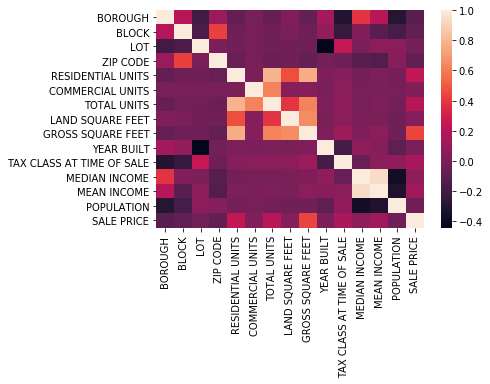

In [152]:
# Correlation between features
corr = train_merged.corr()
print(corr['SALE PRICE'].sort_values(ascending=False))
sns.heatmap(corr)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37153 entries, train0 to test9288
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         37153 non-null  int64  
 1   NEIGHBORHOOD                    37153 non-null  object 
 2   BUILDING CLASS CATEGORY         37153 non-null  object 
 3   TAX CLASS AT PRESENT            37153 non-null  object 
 4   BLOCK                           37153 non-null  int64  
 5   BUILDING CLASS AT PRESENT       37153 non-null  object 
 6   ZIP CODE                        37153 non-null  int64  
 7   RESIDENTIAL UNITS               37153 non-null  int64  
 8   COMMERCIAL UNITS                37153 non-null  int64  
 9   TOTAL UNITS                     37153 non-null  int64  
 10  LAND SQUARE FEET                37153 non-null  float64
 11  GROSS SQUARE FEET               37153 non-null  float64
 12  YEAR BUILT                   

In [157]:
categorical_features = ["BOROUGH", "BUILDING CLASS CATEGORY", "ZIP CODE", "TAX CLASS AT TIME OF SALE"]

del df["BUILDING CLASS AT PRESENT"]
del df["TAX CLASS AT PRESENT"]
del df["BUILDING CLASS AT TIME OF SALE"]

# Too many features for location
del df["BLOCK"]
del df["NEIGHBORHOOD"]

In [158]:
# One-hot encoding
df = pd.get_dummies(df, columns = categorical_features)
df.info(verbose = True, memory_usage = True, null_counts = True)

             37153 non-null  uint8  
 36  BUILDING CLASS CATEGORY_26 OTHER HOTELS                               37153 non-null  uint8  
 37  BUILDING CLASS CATEGORY_27 FACTORIES                                  37153 non-null  uint8  
 38  BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS                          37153 non-null  uint8  
 39  BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES                         37153 non-null  uint8  
 40  BUILDING CLASS CATEGORY_30 WAREHOUSES                                 37153 non-null  uint8  
 41  BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND                     37153 non-null  uint8  
 42  BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES             37153 non-null  uint8  
 43  BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES                     37153 non-null  uint8  
 44  BUILDING CLASS CATEGORY_34 THEATRES                                   37153 non-null  uint8  
 45  BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES   

# Regression

In [159]:
# Split train and test data
from sklearn.model_selection import train_test_split

y = y_train["SALE PRICE"]
X = df.head(27864)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
from sklearn.metrics import mean_squared_error
# Root mean squared error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [170]:
# linear regression
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_valid)
rmse(y_valid, y_pred_lin)

8018162.343900851

In [172]:
linear_submission = pd.DataFrame(linreg.predict(df[27864:]))
linear_submission.index = X_test["id"]
linear_submission.columns = ["SALE PRICE"]
linear_submission.to_csv("linear_submission.csv")
linear_submission.head()

,SALE PRICE
id,
test0,1.393442e+07
test1,6.799121e+05
test2,4.041972e+05
test3,1.922549e+06
test4,2.661554e+06


In [162]:
# Lasso regression
alpha=0.00099
lasso_regr = linear_model.Lasso(alpha = alpha, max_iter = 50000)
lasso_regr.fit(X_train, y_train)
Y_pred_lasso = lasso_regr.predict(X_valid)
rmse(y_valid,Y_pred_lasso)

KeyboardInterrupt: 

In [ ]:
# Ridge regression
ridge = Rlinear_model.idge(alpha= 0 .01, normalize= T rue)
ridge.fit(X_train, Y_y_trainY_pred_ridge = ridge.predict(X_tX_validmse(Y_tey_validred_ridge)

In [163]:
from sklearn.ensemble import RandomForestRegressor

In [165]:
# Random forest
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, y_train)
Y_pred_rf = rf_regr.predict(X_valid)
rmse(y_valid,Y_pred_rf)

8426414.003457213

In [173]:
rf_submission = pd.DataFrame(rf_regr.predict(df[27864:]))
rf_submission.index = X_test["id"]
rf_submission.columns = ["SALE PRICE"]
rf_submission.to_csv("rf_submission.csv")
rf_submission.head()

,SALE PRICE
id,
test0,8.912769e+06
test1,6.338599e+05
test2,5.359389e+05
test3,1.151109e+06
test4,8.897281e+05


## Bad Linear Regression

In [4]:
X = X_train[["LAND SQUARE FEET", "GROSS SQUARE FEET", "MEDIAN INCOME", "MEAN INCOME"]]
Y = y_train["SALE PRICE"]

In [5]:
model = linear_model.LinearRegression()
model.fit(X,Y)
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 -839621.1447765732
Coefficients: 
 [-103.74858556  219.45065715 -134.32839719  131.63102758]


In [6]:
x_test_predictions = pd.DataFrame(model.predict(X_test[["LAND SQUARE FEET", "GROSS SQUARE FEET", "MEDIAN INCOME", "MEAN INCOME"]]))
x_test_predictions.index = X_test["id"]
x_test_predictions.columns = ["SALE PRICE"]
x_test_predictions.to_csv("submission.csv")
x_test_predictions.head()

,SALE PRICE
id,
test0,8.377787e+06
test1,9.576359e+05
test2,1.200801e+06
test3,2.958064e+06
test4,5.319965e+06


# Submit to Kaggle
Run this command to send a submission to the Kaggle competition

In [174]:
!kaggle competitions submit -c saas-2020-fall-cx-kaggle-compeition -f linear_submission.csv -m "Linear 2"

Successfully submitted to SAAS 2020 Fall CX Kaggle Compeition

  0%|          | 0.00/257k [00:00<?, ?B/s]
  3%|▎         | 8.00k/257k [00:00<00:04, 55.3kB/s]
 37%|███▋      | 96.0k/257k [00:00<00:02, 76.8kB/s]
 50%|████▉     | 128k/257k [00:00<00:01, 81.2kB/s] 
 59%|█████▉    | 152k/257k [00:00<00:01, 83.4kB/s]
 69%|██████▊   | 176k/257k [00:01<00:00, 86.1kB/s]
 75%|███████▍  | 192k/257k [00:01<00:00, 86.8kB/s]
 81%|████████  | 208k/257k [00:01<00:00, 88.4kB/s]
 87%|████████▋ | 224k/257k [00:01<00:00, 90.6kB/s]
 94%|█████████▎| 240k/257k [00:01<00:00, 90.5kB/s]
100%|█████████▉| 256k/257k [00:02<00:00, 89.0kB/s]
100%|██████████| 257k/257k [00:04<00:00, 58.3kB/s]
